# Test `storm_surge_alerts` Module

Render figure object produced by the `nowcast.figures.publish.storm_surge_alerts` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

In [1]:
import io
from pathlib import Path

import arrow
import netCDF4 as nc
import scipy.io
import yaml

from salishsea_tools import nc_tools, places

# from nowcast.figures import figures
from nowcast.figures.publish import storm_surge_alerts

In [2]:
%matplotlib inline

In [3]:
config = '''
    bathymetry: /results/nowcast-sys/grid/bathymetry_201702.nc
    coastline: /ocean/rich/more/mmapbase/bcgeo/PNW.mat

    ssh:
        tidal_predictions: /results/nowcast-sys/SalishSeaNowcast/tidal_predictions/

    weather:
        ops_dir: /results/forcing/atmospheric/GEM2.5/operational/

    run:
        results_archive:
            nowcast: /results/SalishSea/nowcast-green/
            forecast: /results/SalishSea/forecast/
'''

config = yaml.load(io.StringIO(config))

In [9]:
run_date = arrow.get('2018-10-19')
run_type = 'forecast'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+1).format('YYYYMMDD'),
}
end_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+2).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy
place_names = places.TIDE_GAUGE_SITES + places.SUPP_TIDE_SITES
weather_path = Path(config['weather']['ops_dir'])
if run_type in ('forecast', ('foreacst2')):
    weather_path = weather_path/'fcst'

In [10]:
bathy = nc.Dataset(config['bathymetry'])
grid_T_hr = nc.Dataset(
    str(results_dir/'SalishSea_1h_{0}_{1}_grid_T.nc'
        .format(start_day[run_type], end_day[run_type])))
grids_15m = {
    place_name: nc.Dataset(str(results_dir/'{}.nc'.format(place_name.replace(' ', ''))))
    for place_name in place_names
}
weather_path= str(weather_path)
coastline = scipy.io.loadmat(config['coastline'])
tidal_predictions = config['ssh']['tidal_predictions']

In [ ]:
%%timeit -n1 -r1

# Reference rendering of figure

fig = figures.plot_threshold_website(bathy, grid_T_hr, grids_15m, weather_path, coastline, tidal_predictions)

5min 53s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


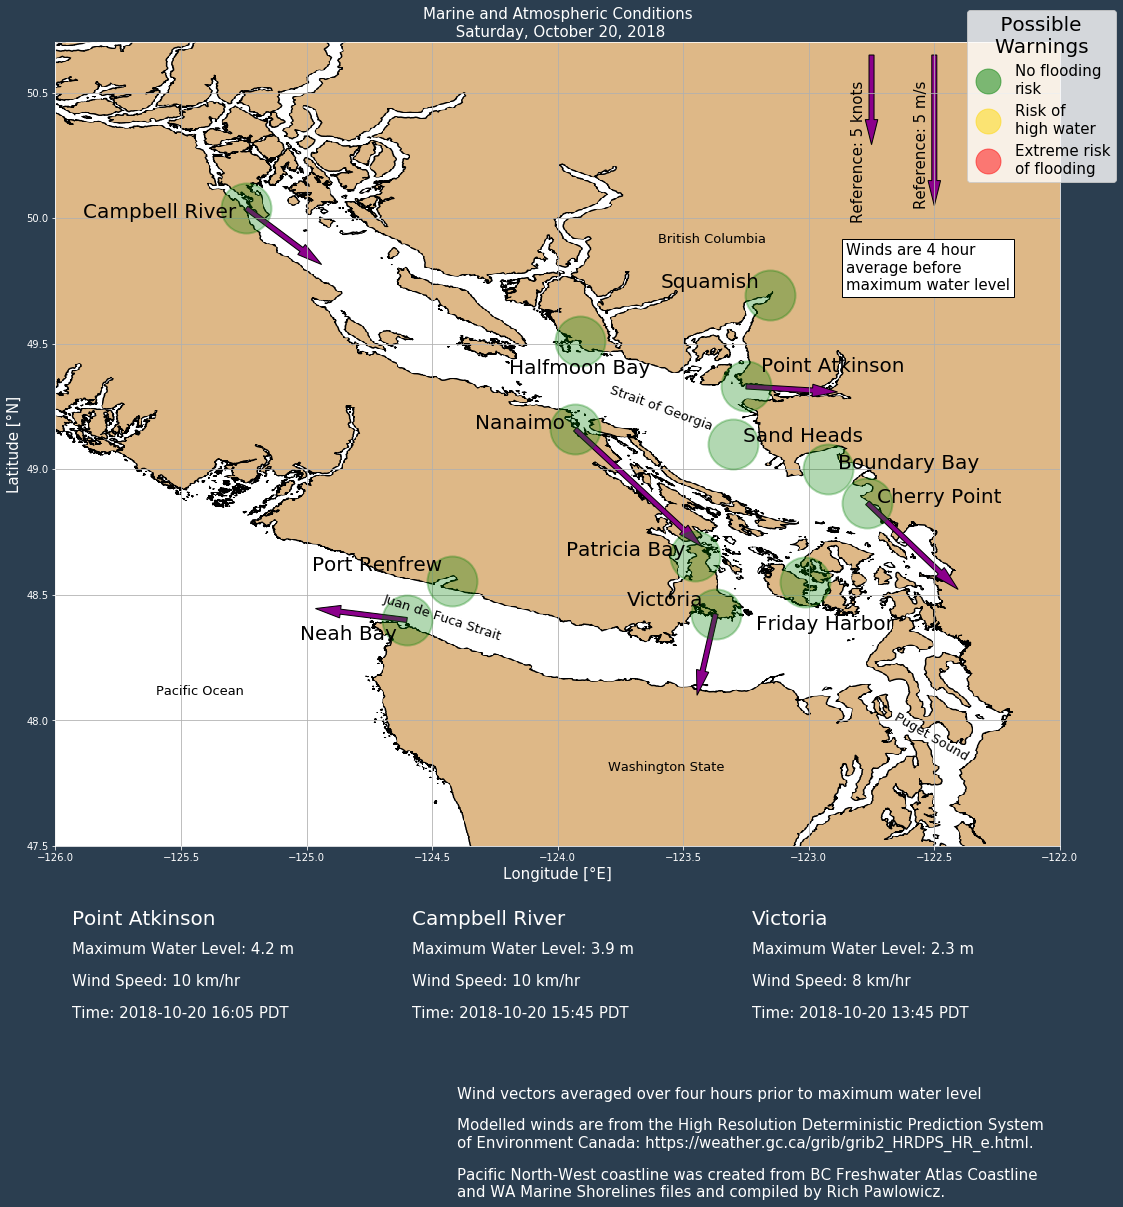

In [11]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme
reload(storm_surge_alerts)
reload(website_theme)

fig = storm_surge_alerts.make_figure(
    grids_15m, weather_path, coastline, tidal_predictions,
    theme=website_theme)